# Bitcoin Price Prediction using Linear Regression

This notebook implements a linear regression model to predict Bitcoin prices using the merged dataset created in the preprocessing notebook and the most important features identified in the Feature Importance analysis.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Load the merged dataset with Bitcoin price
df = pd.read_csv('../data/dataset_merged_with_price.csv', index_col=0, parse_dates=True)
df = df.drop(columns=['av_transaction_size', 'full_name', 'coin', 'confirmation_time'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nDataset columns:")
print(df.columns.tolist())
print(f"\nFirst few rows:")
df.head()

KeyError: "['av_transaction_size'] not found in axis"

## Data Exploration and Preparation

In [ ]:
# Check for missing values
print("Missing values per column:")
missing_values = df.isna().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percentage
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

# Basic statistics
print(f"\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nTarget variable (btc_price) statistics:")
print(df['btc_price'].describe())

Missing values per column:
            Missing Count  Percentage
gold_open               2    0.101215
gold_close              2    0.101215
gold_low                2    0.101215
gold_high               2    0.101215

Dataset Info:
Shape: (1976, 23)
Memory usage: 0.36 MB

Target variable (btc_price) statistics:
count     1976.000000
mean      5617.379008
std       4675.419201
min        213.670000
25%        766.107500
50%       5678.500000
75%       8925.500000
max      27061.000000
Name: btc_price, dtype: float64


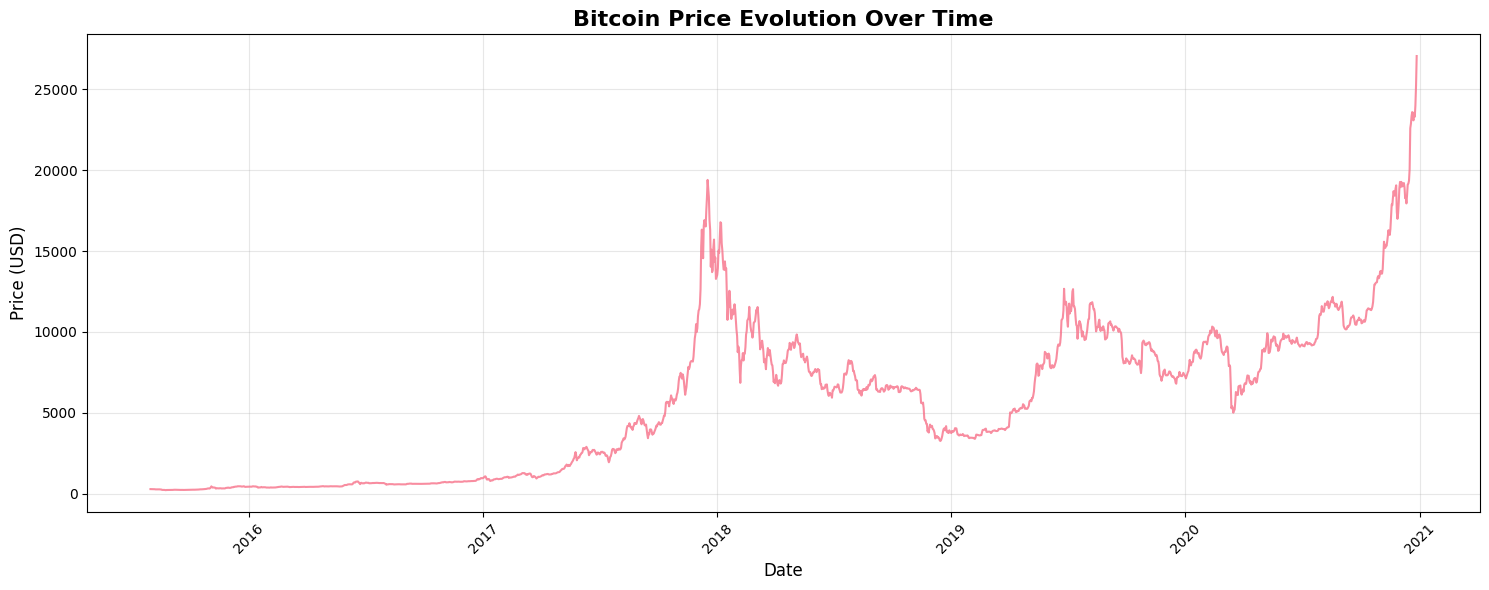

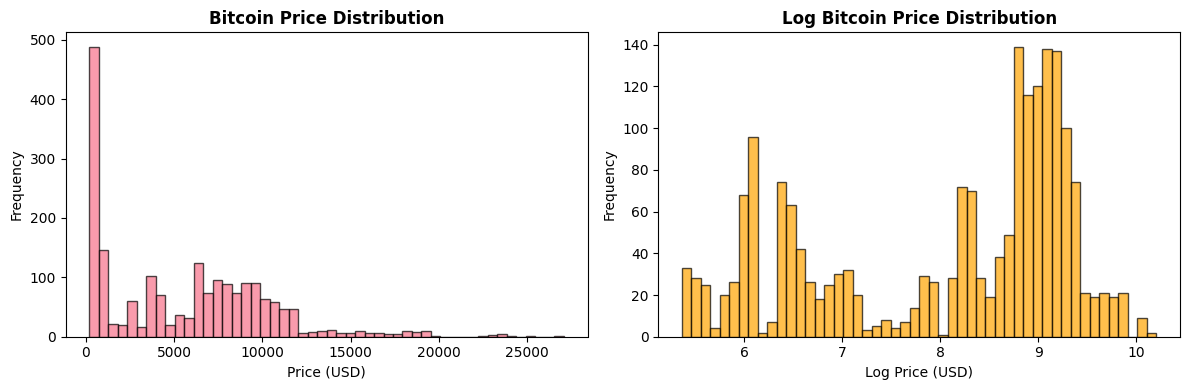

In [ ]:
# Visualize Bitcoin price evolution over time
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['btc_price'], linewidth=1.5, alpha=0.8)
plt.title('Bitcoin Price Evolution Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribution of Bitcoin price
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['btc_price'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Bitcoin Price Distribution', fontweight='bold')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(np.log(df['btc_price']), bins=50, alpha=0.7, edgecolor='black', color='orange')
plt.title('Log Bitcoin Price Distribution', fontweight='bold')
plt.xlabel('Log Price (USD)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Feature Selection Based on Feature Importance Analysis

Based on the Feature Importance notebook analysis, we'll select the most relevant features for predicting Bitcoin price.

In [ ]:
# Define feature sets based on Feature Importance analysis
# These features showed the highest importance in the Feature Importance notebook
important_features = [
    "tweets", "top_100_percent", "transactions", "google_trends",
    "hashrate", "sent_addresses", "median_transaction_size",
    "av_transaction_value", "FEDFUNDS", "gold_close"
]

# Define target variable
target = 'btc_price'

print(f"\nTarget variable: {target}")
print(f"Features to use: {len(important_features)} features")


Target variable: btc_price
Features to use: 10 features


Original dataset shape: (1976, 23)
Clean dataset shape: (1974, 11)
Rows removed: 2 (0.1%)


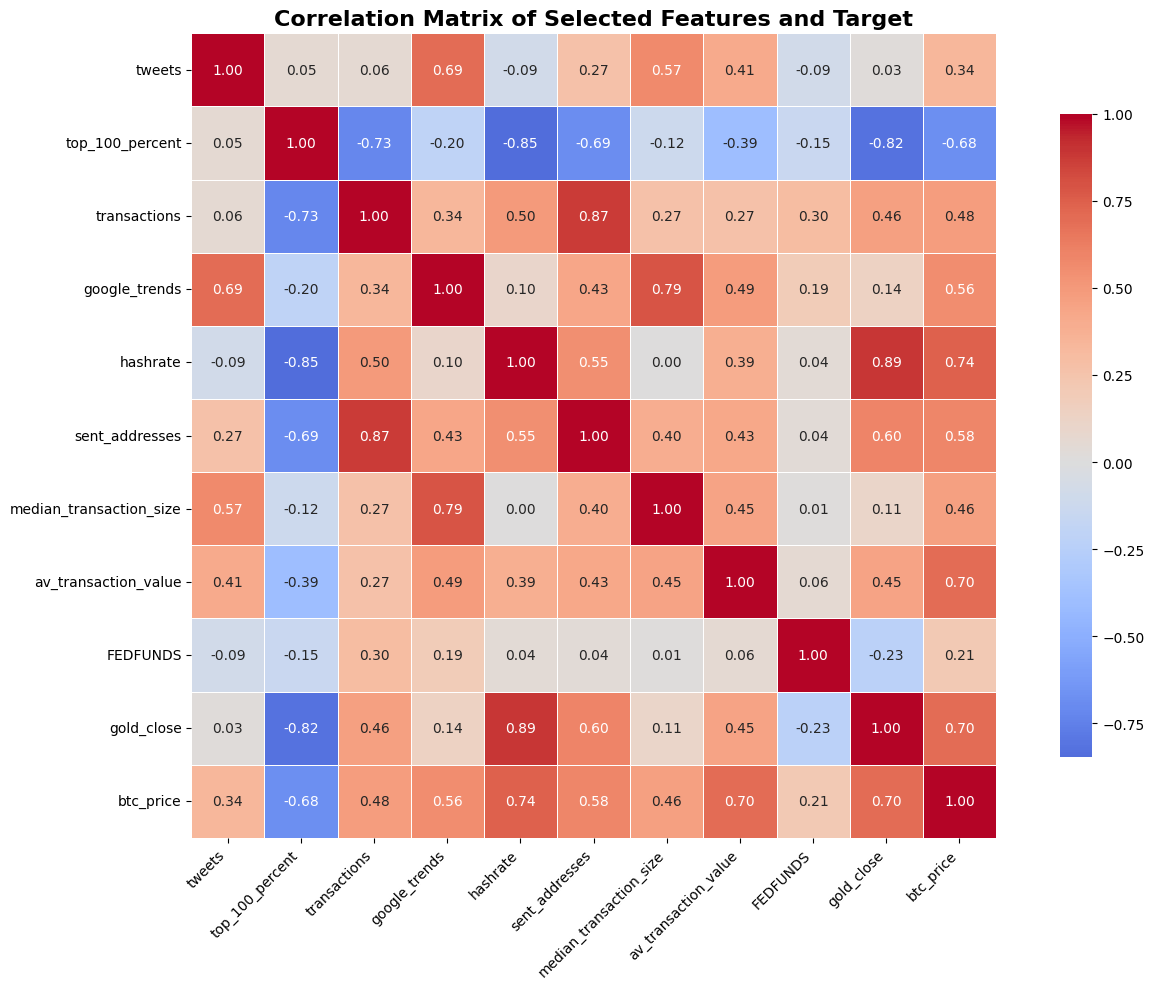


Correlations with btc_price (sorted by absolute value):
hashrate                 :  0.744
gold_close               :  0.701
av_transaction_value     :  0.696
top_100_percent          : -0.677
sent_addresses           :  0.582
google_trends            :  0.556
transactions             :  0.478
median_transaction_size  :  0.459
tweets                   :  0.341
FEDFUNDS                 :  0.215


In [ ]:
# Prepare the dataset by removing rows with missing values in selected features and target(none)
df_clean = df[important_features + [target]].dropna()

print(f"Original dataset shape: {df.shape}")
print(f"Clean dataset shape: {df_clean.shape}")
print(f"Rows removed: {df.shape[0] - df_clean.shape[0]} ({((df.shape[0] - df_clean.shape[0])/df.shape[0]*100):.1f}%)")

# Display correlation matrix for the selected features
plt.figure(figsize=(14, 10))
correlation_matrix = df_clean[important_features + [target]].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Selected Features and Target', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Show correlation with target variable specifically
target_correlations = correlation_matrix[target].drop(target).sort_values(key=abs, ascending=False)
print(f"\nCorrelations with {target} (sorted by absolute value):")
for feature, corr in target_correlations.items():
    print(f"{feature:25}: {corr:6.3f}")

## Data Splitting and Scaling

In [ ]:
# Prepare features and target
X = df_clean[important_features]
y = df_clean[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Date range: {df_clean.index.min()} to {df_clean.index.max()}")

# Split the data into training and testing sets (80-20 split)
# Use temporal split to maintain chronological order
split_index = int(len(df_clean) * 0.8)
split_date = df_clean.index[split_index]

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"\nTraining set:")
print(f"  Period: {X_train.index.min()} to {X_train.index.max()}")
print(f"  Shape: {X_train.shape}")

print(f"\nTesting set:")
print(f"  Period: {X_test.index.min()} to {X_test.index.max()}")
print(f"  Shape: {X_test.shape}")

print(f"\nSplit date: {split_date}")
print(f"Train/Test ratio: {len(X_train)}/{len(X_test)} ({len(X_train)/len(X)*100:.1f}%/{len(X_test)/len(X)*100:.1f}%)")

Features shape: (1974, 10)
Target shape: (1974,)
Date range: 2015-08-03 00:00:00 to 2020-12-27 00:00:00

Training set:
  Period: 2015-08-03 00:00:00 to 2019-11-28 00:00:00
  Shape: (1579, 10)

Testing set:
  Period: 2019-11-29 00:00:00 to 2020-12-27 00:00:00
  Shape: (395, 10)

Split date: 2019-11-29 00:00:00
Train/Test ratio: 1579/395 (80.0%/20.0%)


In [ ]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for easier interpretation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling completed!")
print(f"\nFeature statistics after scaling (training set):")
print("Mean (should be ~0):")
print(X_train_scaled.mean().round(6))
print("\nStandard deviation (should be ~1):")
print(X_train_scaled.std().round(6))

# Display feature scaling comparison for a sample
print(f"\nExample: First feature '{X_train.columns[0]}' scaling:")
print(f"Original range: [{X_train.iloc[:, 0].min():.2f}, {X_train.iloc[:, 0].max():.2f}]")
print(f"Scaled range: [{X_train_scaled.iloc[:, 0].min():.2f}, {X_train_scaled.iloc[:, 0].max():.2f}]")

Feature scaling completed!

Feature statistics after scaling (training set):
Mean (should be ~0):
tweets                     0.0
top_100_percent            0.0
transactions               0.0
google_trends              0.0
hashrate                   0.0
sent_addresses            -0.0
median_transaction_size    0.0
av_transaction_value      -0.0
FEDFUNDS                   0.0
gold_close                -0.0
dtype: float64

Standard deviation (should be ~1):
tweets                     1.000317
top_100_percent            1.000317
transactions               1.000317
google_trends              1.000317
hashrate                   1.000317
sent_addresses             1.000317
median_transaction_size    1.000317
av_transaction_value       1.000317
FEDFUNDS                   1.000317
gold_close                 1.000317
dtype: float64

Example: First feature 'tweets' scaling:
Original range: [0.00, 155600.00]
Scaled range: [-1.57, 5.91]


## Linear Regression Model Training

In [ ]:
# Create and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions on both training and test sets
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

print("Linear Regression Model Training Completed!")
print(f"Model coefficients shape: {lr_model.coef_.shape}")
print(f"Model intercept: {lr_model.intercept_:.2f}")

# Calculate performance metrics
def calculate_metrics(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Set Metrics:")
    print(f"  Mean Squared Error (MSE): {mse:,.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:,.2f}")
    print(f"  Mean Absolute Error (MAE): {mae:,.2f}")
    print(f"  R² Score: {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Calculate metrics for both sets
train_metrics = calculate_metrics(y_train, y_train_pred, "Training")
test_metrics = calculate_metrics(y_test, y_test_pred, "Testing")

Linear Regression Model Training Completed!
Model coefficients shape: (10,)
Model intercept: 4378.09

Training Set Metrics:
  Mean Squared Error (MSE): 1,518,869.65
  Root Mean Squared Error (RMSE): 1,232.42
  Mean Absolute Error (MAE): 874.69
  R² Score: 0.9042

Testing Set Metrics:
  Mean Squared Error (MSE): 12,278,452.43
  Root Mean Squared Error (RMSE): 3,504.06
  Mean Absolute Error (MAE): 3,145.16
  R² Score: 0.1729


## Model Evaluation and Visualization

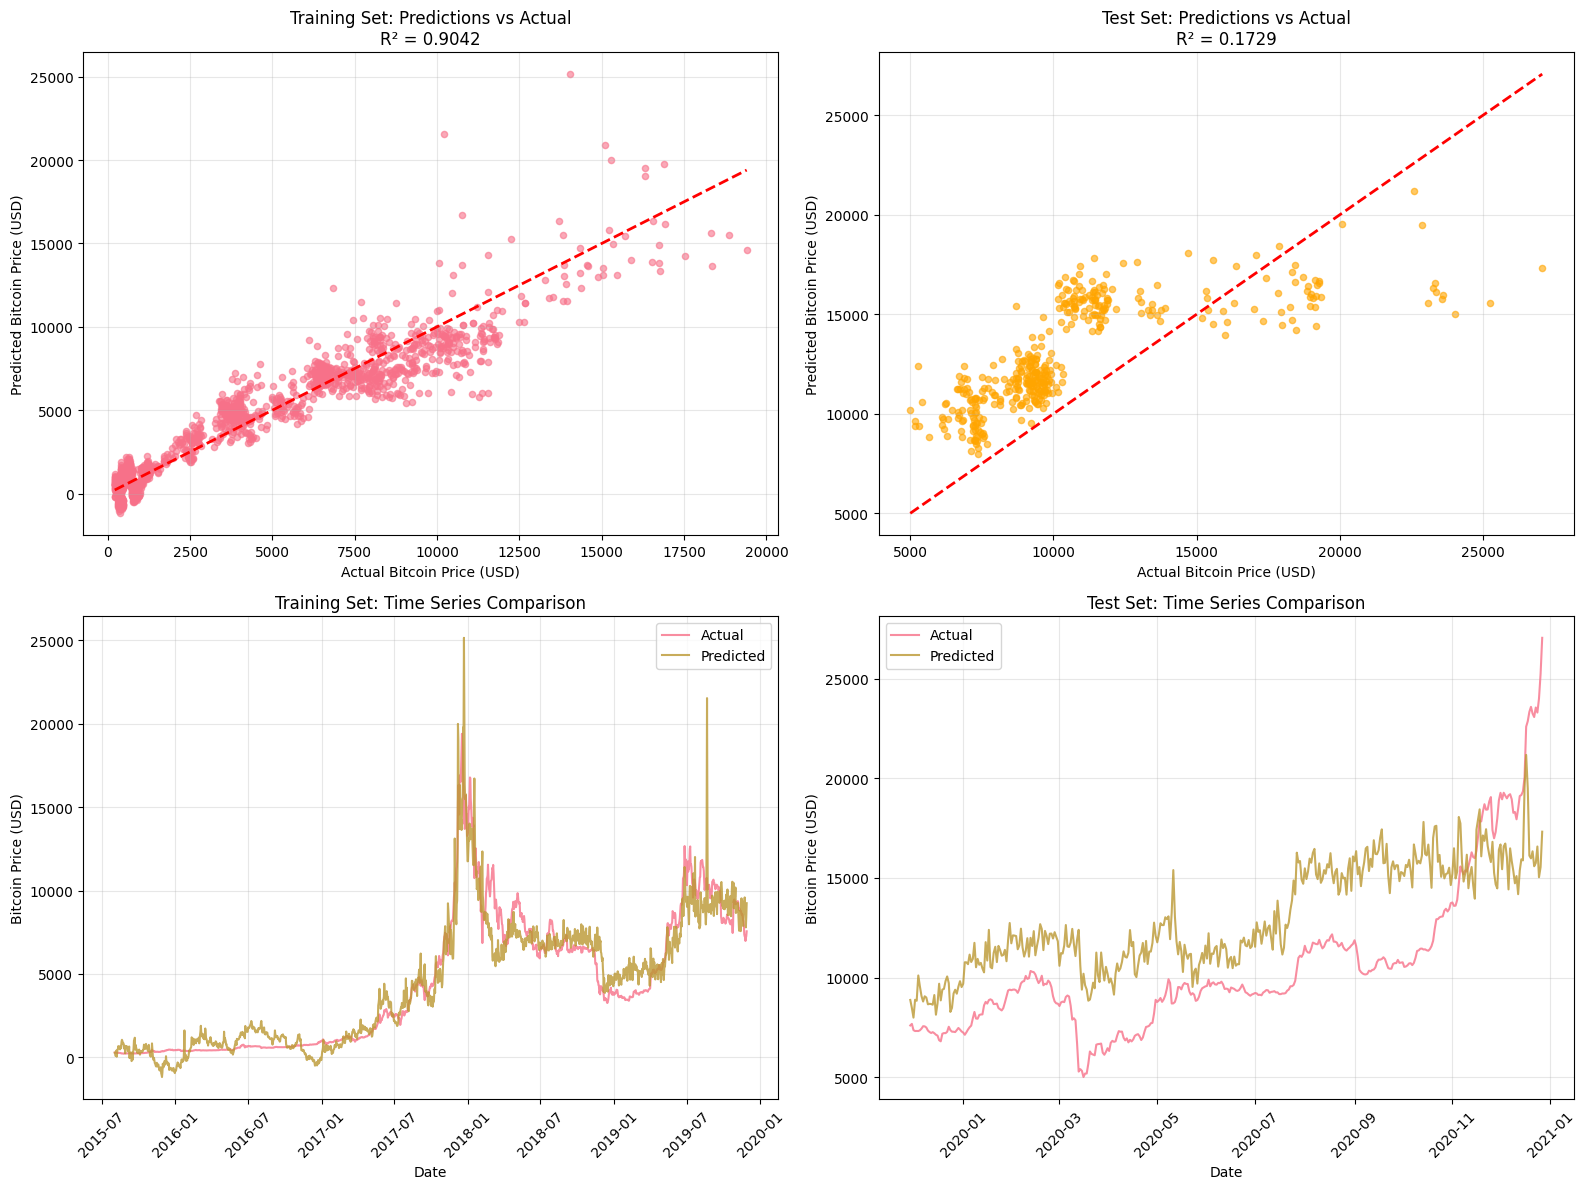

In [ ]:
# Plot predictions vs actual values
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Training set: Predictions vs Actual
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.6, s=20)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Bitcoin Price (USD)')
axes[0, 0].set_ylabel('Predicted Bitcoin Price (USD)')
axes[0, 0].set_title(f'Training Set: Predictions vs Actual\nR² = {train_metrics["R2"]:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# Test set: Predictions vs Actual
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.6, s=20, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Bitcoin Price (USD)')
axes[0, 1].set_ylabel('Predicted Bitcoin Price (USD)')
axes[0, 1].set_title(f'Test Set: Predictions vs Actual\nR² = {test_metrics["R2"]:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# Time series plot: Training
axes[1, 0].plot(y_train.index, y_train.values, label='Actual', alpha=0.8, linewidth=1.5)
axes[1, 0].plot(y_train.index, y_train_pred, label='Predicted', alpha=0.8, linewidth=1.5)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Bitcoin Price (USD)')
axes[1, 0].set_title('Training Set: Time Series Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Time series plot: Testing
axes[1, 1].plot(y_test.index, y_test.values, label='Actual', alpha=0.8, linewidth=1.5)
axes[1, 1].plot(y_test.index, y_test_pred, label='Predicted', alpha=0.8, linewidth=1.5)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Bitcoin Price (USD)')
axes[1, 1].set_title('Test Set: Time Series Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

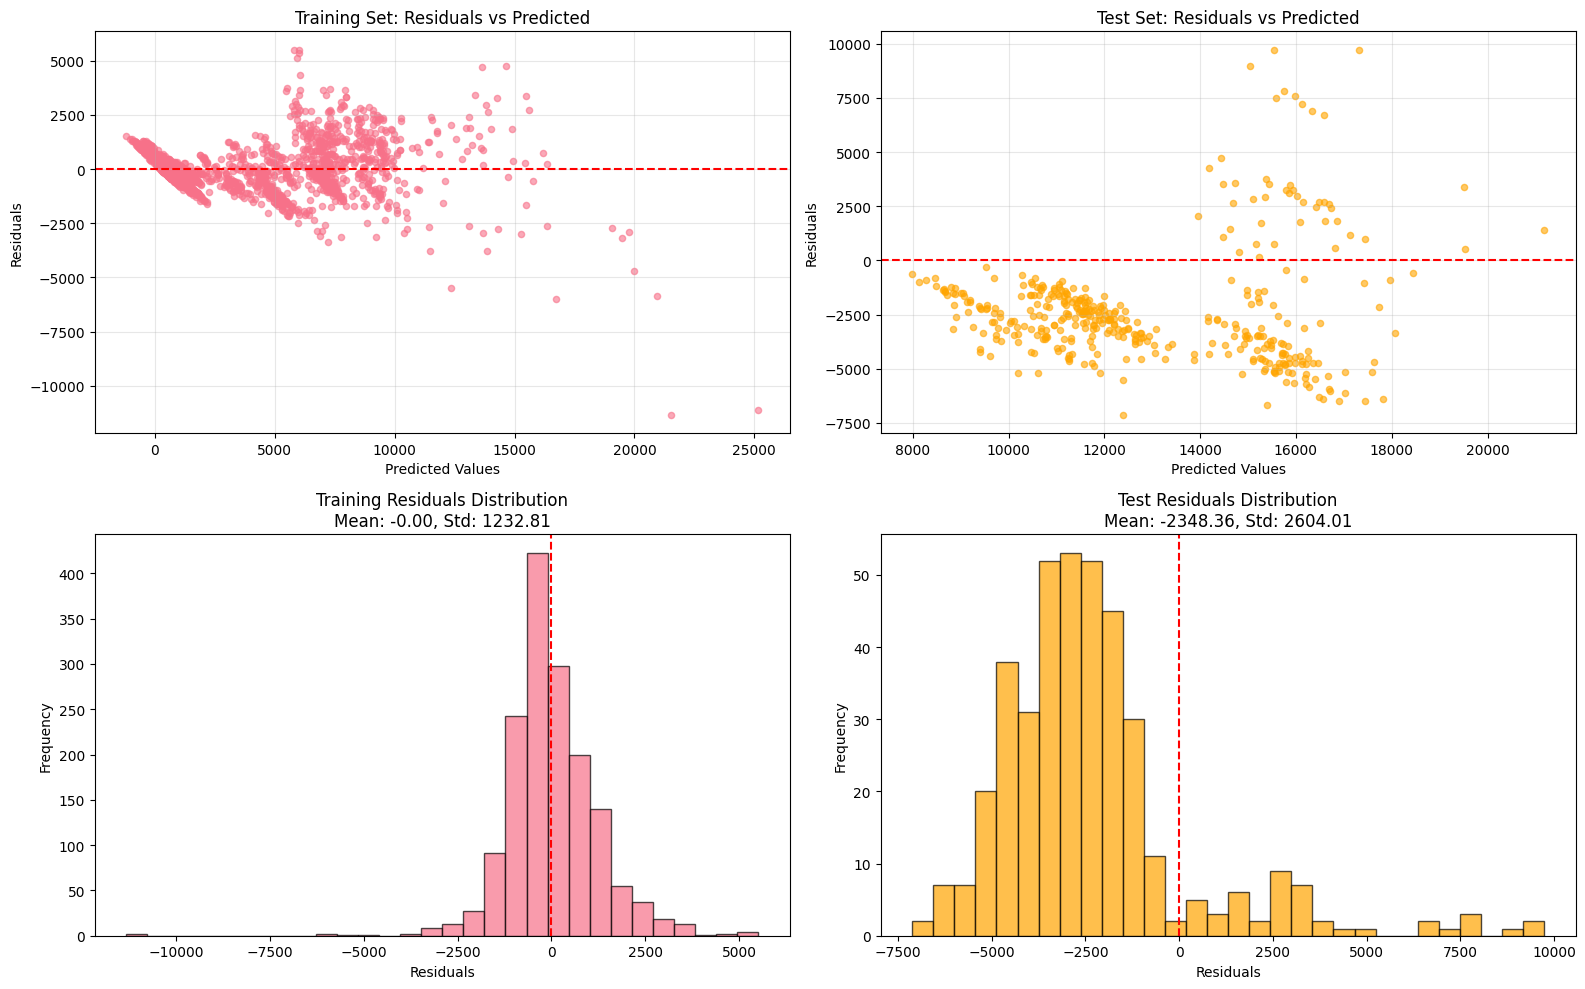

Residuals Analysis:

Training Set Residuals:
  Mean: -0.0000
  Standard Deviation: 1232.81
  Min: -11322.80
  Max: 5508.42

Test Set Residuals:
  Mean: -2348.3554
  Standard Deviation: 2604.01
  Min: -7118.99
  Max: 9735.27


In [ ]:
# Residual analysis
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Training residuals vs predicted values
axes[0, 0].scatter(y_train_pred, train_residuals, alpha=0.6, s=20)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Training Set: Residuals vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

# Test residuals vs predicted values
axes[0, 1].scatter(y_test_pred, test_residuals, alpha=0.6, s=20, color='orange')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Test Set: Residuals vs Predicted')
axes[0, 1].grid(True, alpha=0.3)

# Training residuals distribution
axes[1, 0].hist(train_residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Training Residuals Distribution\nMean: {train_residuals.mean():.2f}, Std: {train_residuals.std():.2f}')

# Test residuals distribution
axes[1, 1].hist(test_residuals, bins=30, alpha=0.7, edgecolor='black', color='orange')
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Test Residuals Distribution\nMean: {test_residuals.mean():.2f}, Std: {test_residuals.std():.2f}')

plt.tight_layout()
plt.show()

# Statistical summary of residuals
print("Residuals Analysis:")
print(f"\nTraining Set Residuals:")
print(f"  Mean: {train_residuals.mean():.4f}")
print(f"  Standard Deviation: {train_residuals.std():.2f}")
print(f"  Min: {train_residuals.min():.2f}")
print(f"  Max: {train_residuals.max():.2f}")

print(f"\nTest Set Residuals:")
print(f"  Mean: {test_residuals.mean():.4f}")
print(f"  Standard Deviation: {test_residuals.std():.2f}")
print(f"  Min: {test_residuals.min():.2f}")
print(f"  Max: {test_residuals.max():.2f}")

## Feature Coefficients Analysis

Linear Regression Coefficients (sorted by absolute value):
hashrate                 :  1895.04 (Bitcoin price increases)
top_100_percent          :  1074.88 (Bitcoin price increases)
google_trends            :  1064.55 (Bitcoin price increases)
FEDFUNDS                 :  1036.67 (Bitcoin price increases)
gold_close               :   922.08 (Bitcoin price increases)
median_transaction_size  :   806.97 (Bitcoin price increases)
av_transaction_value     :   566.29 (Bitcoin price increases)
tweets                   :   356.80 (Bitcoin price increases)
transactions             :  -272.73 (Bitcoin price decreases)
sent_addresses           :   208.19 (Bitcoin price increases)

Intercept: 4378.09


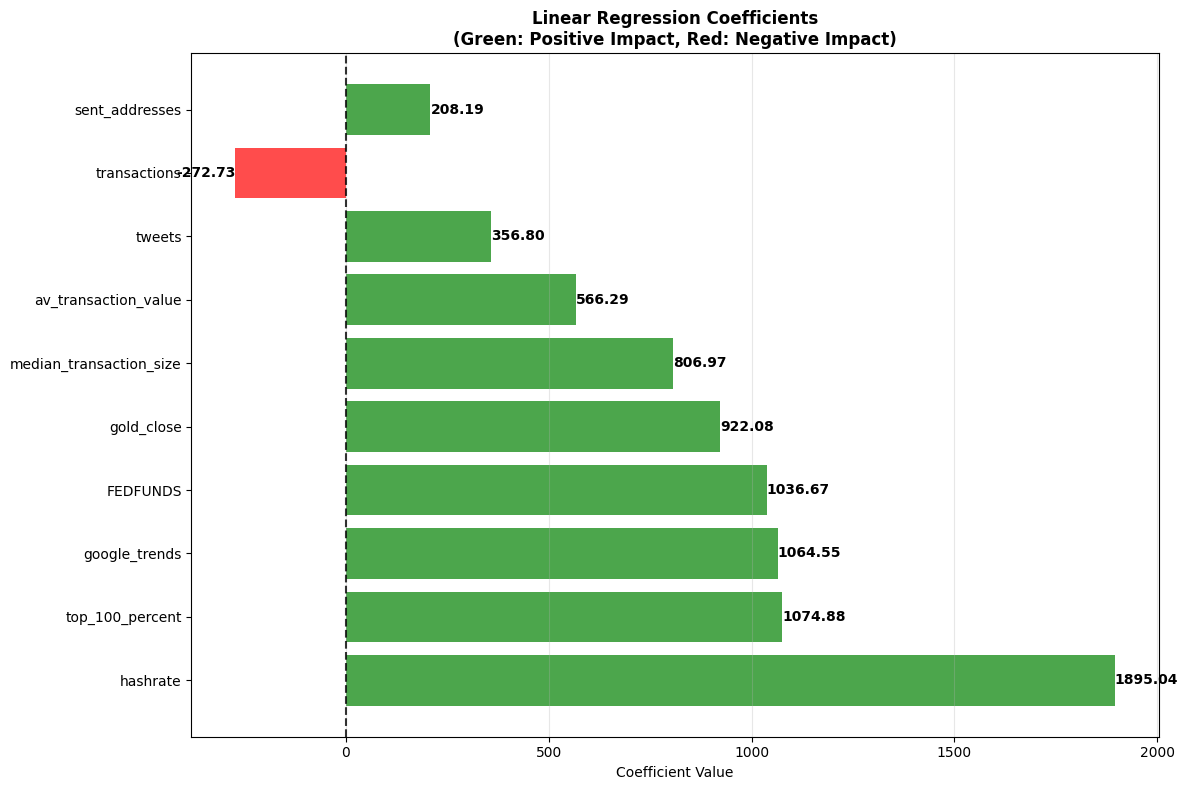

In [ ]:
# Analyze feature coefficients
coefficients = pd.DataFrame({
    'Feature': important_features,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("Linear Regression Coefficients (sorted by absolute value):")
print("=" * 60)
for _, row in coefficients.iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"{row['Feature']:25}: {row['Coefficient']:8.2f} (Bitcoin price {direction})")

print(f"\nIntercept: {lr_model.intercept_:.2f}")

# Visualize coefficients
plt.figure(figsize=(12, 8))
colors = ['green' if coef > 0 else 'red' for coef in coefficients['Coefficient']]
bars = plt.barh(range(len(coefficients)), coefficients['Coefficient'], color=colors, alpha=0.7)

plt.yticks(range(len(coefficients)), coefficients['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Linear Regression Coefficients\n(Green: Positive Impact, Red: Negative Impact)', fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.8)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, coef) in enumerate(zip(bars, coefficients['Coefficient'])):
    plt.text(coef + (0.1 if coef > 0 else -0.1), i, f'{coef:.2f}', 
             ha='left' if coef > 0 else 'right', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

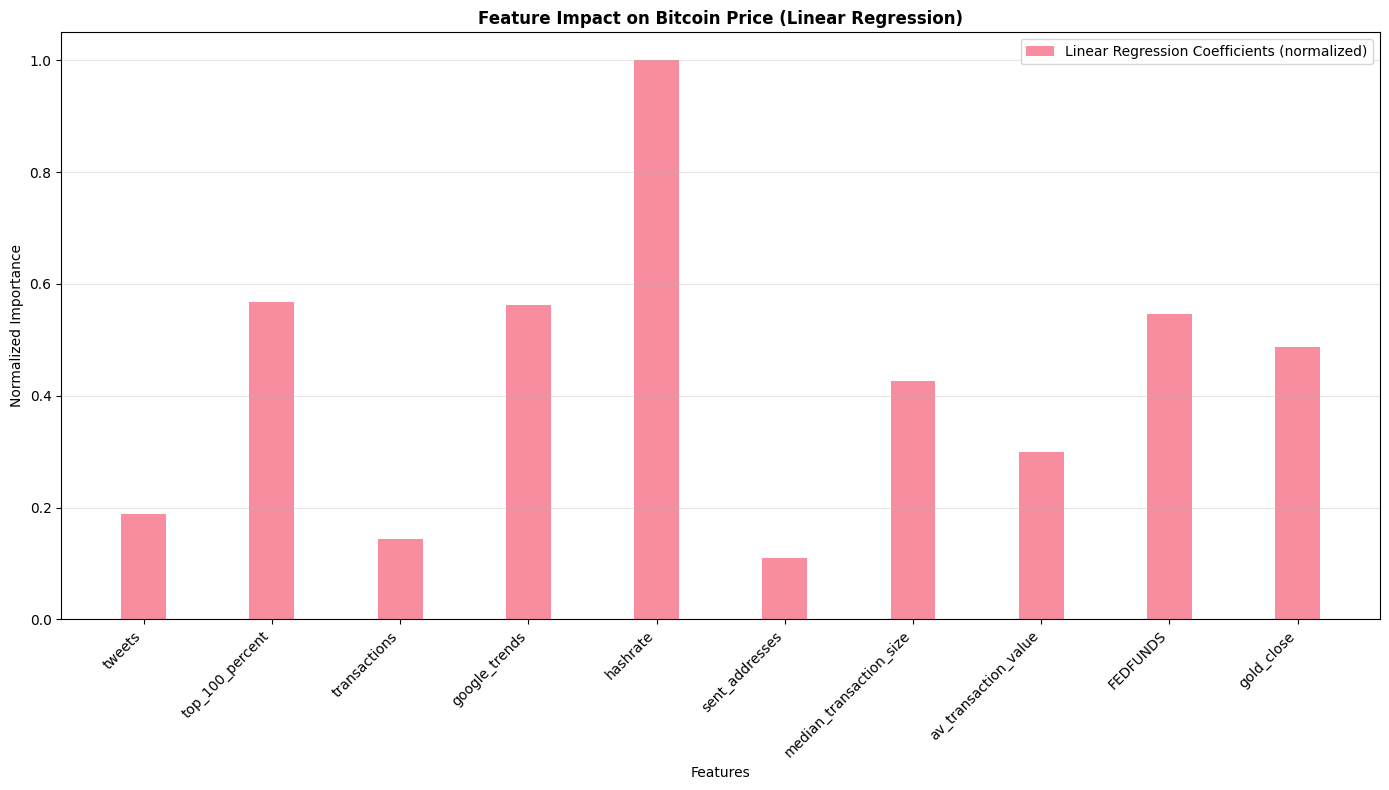


Model Summary:
Number of features used: 10
Training R² score: 0.9042
Test R² score: 0.1729
Training RMSE: $1,232.42
Test RMSE: $3,504.06

Most influential features (top 5):
1. hashrate: 1895.0397
2. top_100_percent: 1074.8832
3. google_trends: 1064.5513
4. FEDFUNDS: 1036.6667
5. gold_close: 922.0765

Overfitting analysis:
R² difference (train - test): 0.7313
RMSE ratio (test / train): 2.843
⚠️  Potential overfitting detected (large R² difference)


In [ ]:
# Compare feature importance (from Feature Importance notebook) with linear regression coefficients
plt.figure(figsize=(14, 8))

# Create a comparison chart
x_pos = np.arange(len(important_features))
width = 0.35

# For this comparison, we'll use the absolute values of coefficients (normalized)
normalized_coef = coefficients.set_index('Feature')['Abs_Coefficient'] / coefficients['Abs_Coefficient'].max()

# Note: Feature importance values would need to be calculated or imported
# For demonstration, we'll show just the coefficients
plt.bar(x_pos, normalized_coef[important_features], width, 
        label='Linear Regression Coefficients (normalized)', alpha=0.8)

plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.title('Feature Impact on Bitcoin Price (Linear Regression)', fontweight='bold')
plt.xticks(x_pos, important_features, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nModel Summary:")
print(f"=" * 50)
print(f"Number of features used: {len(important_features)}")
print(f"Training R² score: {train_metrics['R2']:.4f}")
print(f"Test R² score: {test_metrics['R2']:.4f}")
print(f"Training RMSE: ${train_metrics['RMSE']:,.2f}")
print(f"Test RMSE: ${test_metrics['RMSE']:,.2f}")

print(f"\nMost influential features (top 5):")
for i, (_, row) in enumerate(coefficients.head().iterrows()):
    print(f"{i+1}. {row['Feature']}: {row['Coefficient']:.4f}")

print(f"\nOverfitting analysis:")
r2_diff = train_metrics['R2'] - test_metrics['R2']
rmse_ratio = test_metrics['RMSE'] / train_metrics['RMSE']
print(f"R² difference (train - test): {r2_diff:.4f}")
print(f"RMSE ratio (test / train): {rmse_ratio:.3f}")
if r2_diff > 0.1:
    print("⚠️  Potential overfitting detected (large R² difference)")
elif rmse_ratio > 1.2:
    print("⚠️  Potential overfitting detected (high RMSE ratio)")
else:
    print("✅ Model shows good generalization")

## Conclusions and Next Steps

### Model Performance Summary
- The linear regression model has been successfully trained to predict Bitcoin prices
- Feature selection was based on the Feature Importance analysis from the previous notebook
- Model evaluation includes comprehensive metrics and visualizations

### Key Findings
1. **Feature Impact**: The model identifies which factors most strongly influence Bitcoin price changes
2. **Predictive Power**: R² scores indicate the model's ability to explain price variance
3. **Residual Analysis**: Helps identify potential model limitations and assumptions

### Potential Improvements
- Consider polynomial features for non-linear relationships
- Apply regularization techniques (Ridge, Lasso) to handle multicollinearity
- Explore ensemble methods for better predictive performance
- Implement time-series specific approaches (ARIMA, LSTM) for temporal patterns